In [1]:
# Before execute any code, go to the terminal and create a ticket to connect to datalake
# Commands:
#   kinit <cpf>@DATALAKE.SERPRO
#   password: mesma senha do HUE
#   klist
%load_ext autoreload
%autoreload 2

# Conexão com o Datalake
#import datalake_serpro
#from datalake_serpro import conectando # used to conect to the datalake
#from datalake_serpro import handler_dl

# Estruturas de dados
import numpy as np
import pandas as pd
pd.options.display.max_rows     = None
pd.options.display.max_columns  = 100
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_colwidth = 1000

# Machine Learning
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.cluster import KMeans

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

#from sklearn.metrics import plot_confusion_matrix
#from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, classification_report

# graphic
import matplotlib.pyplot as plt

# others
import re
import util
from IPython.display import HTML


df_di     = None
adicao_df = None

import gc


In [2]:
# Loading types
train_encoded_df_dtypes = pd.read_csv('train_encoded_df_dtypes.csv', index_col=0)
# Getting columns names
cols_names = train_encoded_df_dtypes.index.values.tolist()
# Getting columns types dict
cols_dtype = train_encoded_df_dtypes.to_dict()['col_type']
# Loading train_encoded_df - #train_encoded_df = pd.DataFrame('train_encoded_df.csv')
train_encoded_df = pd.read_csv('train_encoded_df.csv', dtype=cols_dtype, index_col=0)
train_encoded_df.head()

# loading col_list_df
cols_list_df = pd.read_csv('cols_list_df.csv', index_col=0)
display(cols_list_df.head())

# Loading eval_df
cols_dtypes = pd.read_csv('eval_df_dtypes.csv', index_col=0).to_dict()['col_type']
eval_df = pd.read_csv('eval_df.csv', index_col=0, dtype=cols_dtypes)
index = pd.MultiIndex.from_tuples(tuple(zip(eval_df.index.values.tolist(), eval_df['Unnamed: 1'].values.tolist())), names=['ds_name', 'metric'] )
eval_df = eval_df.set_index(index).drop(columns=['Unnamed: 1'])
display(eval_df)

# saving train_encoded_df because it will be changed
original_df = train_encoded_df

,col_name,encoded
0,cd_di,none
1,cd_uan4_desp,none
2,nm_recinto_alfand,True
3,nm_loc_embq_imp,True
4,nm_modal_desp,True


knn  log_reg  decision_tree  \
ds_name      metric                                                
original_enc fit_time_mean         45.47    53.42           7.28   
             score_time_mean      119.89    22.51          11.58   
             test_accuracy_mean     0.69     0.63           0.63   
             train_accuracy_mean    0.80     0.63           0.63   
             test_precision_mean    0.74     0.65           0.63   
             train_precision_mean   0.83     0.66           0.62   
             test_recall_mean       0.78     0.85           1.00   
             train_recall_mean      0.86     0.85           1.00   
             test_f1_mean           0.76     0.74           0.77   
             train_f1_mean          0.84     0.74           0.77   

                                   random_florest  
ds_name      metric                                
original_enc fit_time_mean                   6.76  
             score_time_mean                11.51  
             test_accuracy_mean              0.63  
             train_accuracy_mean             0.63  
             test_precision_mean             0.62  
             train_precision_mean            0.62  
             test_recall_mean                1.00  
             train_recall_mean               1.00  
             test_f1_mean                    0.77  
             train_f1_mean                   0.77

### Encoding NCM

In [3]:
import numpy as np 
# getting cols not encoded - they will be used to group the data
#group_cols = train_encoded_df.columns[:35].values.tolist()
#group_cols.remove('cd_subitem_ncm')

# define one hot encoding
encoder = OneHotEncoder(sparse=True)
# encode data - cd_subitem
enconded_data = encoder.fit_transform(np.array(train_encoded_df['cd_subitem_ncm']).reshape(-1,1))

encoded_df = pd.DataFrame(enconded_data.toarray(), columns=encoder.categories_, index=train_encoded_df.index )
#display(encoded_df.iloc[:,:10].reset_index(drop=True).head())
train_enc_ncm_df = train_encoded_df.merge(encoded_df, left_index=True, right_index=True, how='inner').drop(columns=['cd_subitem_ncm'])
train_enc_ncm_df.columns = [str(x[0]) if type(x) is tuple else x for  x in train_enc_ncm_df.columns.values]
train_enc_ncm_df.groupby(['39269090.0', '73181500.0', '40169300.0'], as_index=False).agg({"cd_uan4_desp":"count"})

/opt/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


,39269090.0,73181500.0,40169300.0,cd_uan4_desp
0,0.00,0.00,0.00,29622
1,0.00,0.00,1.00,380
2,0.00,1.00,0.00,430
3,1.00,0.00,0.00,533


In [4]:
# It was created a util.py file, so the notebooks can share functions
eval_aux_df = util.evaluate_models(ds_name='train_enc_ncm_df', df=train_enc_ncm_df, frac_di=0.5)
eval_df = eval_df.append(eval_aux_df)
eval_df

Testando Classifier: knn
Testando Classifier: log_reg
Testando Classifier: decision_tree
Testando Classifier: random_florest


knn  log_reg  decision_tree  \
ds_name          metric                                                
original_enc     fit_time_mean         45.47    53.42           7.28   
                 score_time_mean      119.89    22.51          11.58   
                 test_accuracy_mean     0.69     0.63           0.63   
                 train_accuracy_mean    0.80     0.63           0.63   
                 test_precision_mean    0.74     0.65           0.63   
                 train_precision_mean   0.83     0.66           0.62   
                 test_recall_mean       0.78     0.85           1.00   
                 train_recall_mean      0.86     0.85           1.00   
                 test_f1_mean           0.76     0.74           0.77   
                 train_f1_mean          0.84     0.74           0.77   
train_enc_ncm_df fit_time_mean         41.84 1,552.19          16.43   
                 score_time_mean      210.62   102.85          26.61   
                 test_accuracy_mean     0.84     0.60           0.62   
                 train_accuracy_mean    0.89     0.60           0.63   
                 test_precision_mean    0.86     0.60           0.63   
                 train_precision_mean   0.91     0.60           0.64   
                 test_recall_mean       0.87     0.98           0.88   
                 train_recall_mean      0.91     0.98           0.89   
                 test_f1_mean           0.87     0.74           0.74   
                 train_f1_mean          0.91     0.75           0.74   

                                       random_florest  
ds_name          metric                                
original_enc     fit_time_mean                   6.76  
                 score_time_mean                11.51  
                 test_accuracy_mean              0.63  
                 train_accuracy_mean             0.63  
                 test_precision_mean             0.62  
                 train_precision_mean            0.62  
                 test_recall_mean                1.00  
                 train_recall_mean               1.00  
                 test_f1_mean                    0.77  
                 train_f1_mean                   0.77  
train_enc_ncm_df fit_time_mean                  15.15  
                 score_time_mean                26.78  
                 test_accuracy_mean              0.62  
                 train_accuracy_mean             0.62  
                 test_precision_mean             0.61  
                 train_precision_mean            0.61  
                 test_recall_mean                1.00  
                 train_recall_mean               1.00  
                 test_f1_mean                    0.76  
                 train_f1_mean                   0.76

### Níel da DI
- Os dados serão agregados de forma que hava apenas uma linha por DI

In [5]:
# Grouping columns
group_cols = train_enc_ncm_df.columns.values.tolist()[:34]

# The encoded columns will be summed
train_encoded_grouped_df = train_enc_ncm_df.groupby(group_cols).sum()

print(f'Tamanho do Dataset: {len(train_encoded_grouped_df)}')

#    After grouping, some binary columns may have a value greater than 1 beacuse one DI can have more than one line and
# there will be the number one for each line for the modal_despacho column.
#    so we need to transform this values to 1 in order to column remain binary 
# The grouping columns are the index, so we can transforme the other columns
train_encoded_grouped_df = train_encoded_grouped_df.apply(lambda s: s.apply(lambda cell: 1 if cell > 0 else 0))
# Now, the index will be resetd so the gorup columns are transformed to columns
train_encoded_grouped_df = train_encoded_grouped_df.reset_index()

aux_df = train_encoded_grouped_df.groupby('cd_di', as_index=False).agg({'cd_uan4_desp':'count'}).rename(columns={'cd_uan4_desp':'count'})
print(f"Dis com mais de uma linha:{aux_df[aux_df['count'] > 1]}")


Tamanho do Dataset: 9999
Dis com mais de uma linha:Empty DataFrame
Columns: [cd_di, count]
Index: []


In [6]:
# Evaluating dataset
eval_aux_df = util.evaluate_models(ds_name='ncm_enc_di_level_full', df=train_encoded_grouped_df, frac_di=0.5)
eval_df = eval_df.append(eval_aux_df)
eval_df

Testando Classifier: knn
Testando Classifier: log_reg
Testando Classifier: decision_tree
Testando Classifier: random_florest


knn  log_reg  decision_tree  \
ds_name               metric                                                
original_enc          fit_time_mean         45.47    53.42           7.28   
                      score_time_mean      119.89    22.51          11.58   
                      test_accuracy_mean     0.69     0.63           0.63   
                      train_accuracy_mean    0.80     0.63           0.63   
                      test_precision_mean    0.74     0.65           0.63   
                      train_precision_mean   0.83     0.66           0.62   
                      test_recall_mean       0.78     0.85           1.00   
                      train_recall_mean      0.86     0.85           1.00   
                      test_f1_mean           0.76     0.74           0.77   
                      train_f1_mean          0.84     0.74           0.77   
train_enc_ncm_df      fit_time_mean         41.84 1,552.19          16.43   
                      score_time_mean      210.62   102.85          26.61   
                      test_accuracy_mean     0.84     0.60           0.62   
                      train_accuracy_mean    0.89     0.60           0.63   
                      test_precision_mean    0.86     0.60           0.63   
                      train_precision_mean   0.91     0.60           0.64   
                      test_recall_mean       0.87     0.98           0.88   
                      train_recall_mean      0.91     0.98           0.89   
                      test_f1_mean           0.87     0.74           0.74   
                      train_f1_mean          0.91     0.75           0.74   
ncm_enc_di_level_full fit_time_mean          9.57    53.73           3.82   
                      score_time_mean       89.26    17.46           5.72   
                      test_accuracy_mean     0.55     0.51           0.59   
                      train_accuracy_mean    0.71     0.52           0.60   
                      test_precision_mean    0.55     0.53           0.59   
                      train_precision_mean   0.71     0.55           0.60   
                      test_recall_mean       0.56     0.20           0.64   
                      train_recall_mean      0.70     0.21           0.65   
                      test_f1_mean           0.55     0.28           0.59   
                      train_f1_mean          0.71     0.30           0.60   

                                            random_florest  
ds_name               metric                                
original_enc          fit_time_mean                   6.76  
                      score_time_mean                11.51  
                      test_accuracy_mean              0.63  
                      train_accuracy_mean             0.63  
                      test_precision_mean             0.62  
                      train_precision_mean            0.62  
                      test_recall_mean                1.00  
                      train_recall_mean               1.00  
                      test_f1_mean                    0.77  
                      train_f1_mean                   0.77  
train_enc_ncm_df      fit_time_mean                  15.15  
                      score_time_mean                26.78  
                      test_accuracy_mean              0.62  
                      train_accuracy_mean             0.62  
                      test_precision_mean             0.61  
                      train_precision_mean            0.61  
                      test_recall_mean                1.00  
                      train_recall_mean               1.00  
                      test_f1_mean                    0.76  
                      train_f1_mean                   0.76  
ncm_enc_di_level_full fit_time_mean                   3.42  
                      score_time_mean                 5.56  
                      test_accuracy_mean              0.57  
                      train_accuracy_mean             0.

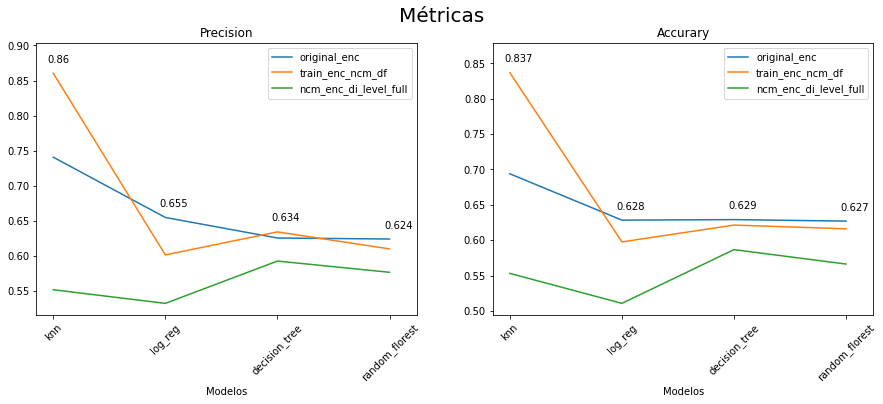

In [7]:
util.plot_eval_graphic(eval_df)

- Pela análise dos gráficos acima, verifica-se que a gregação dos dados para o nível da di ocasionou uma queda brusca tanto na acurácia quanto na precisão. Dessa forma, o dataframe contendo o agrupamento será descartado e o último dataframe que apresentou ganho de performance (train_enc_ncm_df - contendo codificação das NCMs) será utilizado nas transformações subsequentes.

### Normalização ou padronização de dados
- Quando o desvio padrão é muito grande, há necessidade de se posicionarem os dados em uma ordem de grandeza mais semelhante.
- As técnicas utilizadas para isso podem são a normalização (posicionar os dados entre 0 e 1) e a padronização (converter os dados para unidades de desvio padrão - média=0 e desvio padrão passa a ser 1)
- Indicação:
   - Nornalização: distribuição não gaussiana ou desvio padrão baixo.
   - Padronização: demais casos

In [8]:
# getting float columns to be normalized
# Using the last dataframe that presented positive results over the metrics
float_columns = train_enc_ncm_df.columns.values.tolist()[:34] # Columns beyond index 33 are columns resulted from the encode process
float_columns.remove('cd_di')
float_columns = train_enc_ncm_df[float_columns].dtypes[train_enc_ncm_df[float_columns].dtypes == 'float64'].index.values.tolist()
print(f"Colunas reais: {float_columns}")

Colunas reais: ['vmle_dolar_imp_di', 'vmcv_dolar_imp_di', 'vl_frete_dolar_imp_di', 'vl_seguro_dolar_imp_di', 'vl_cif_dolar_imp_di', 'peso_liq_merc_imp_di', 'peso_bruto_carga_imp_di', 'acrescimo_dolar_imp_di', 'deducao_dolar_imp_di', 'ii_recolher_dolar_imp_di', 'ipi_recolher_dolar_imp_di', 'pis_recolher_dolar_imp_di', 'cofins_recolher_dolar_imp_di']


#### Verificação do desvio padrão

In [9]:
# Creating a new dataframe, initialy, having only the columns to be normalized
train_enc_ncm_norm_df = train_enc_ncm_df[float_columns]
train_enc_ncm_norm_df.describe().drop(index=['max','min'])

,vmle_dolar_imp_di,vmcv_dolar_imp_di,vl_frete_dolar_imp_di,vl_seguro_dolar_imp_di,vl_cif_dolar_imp_di,peso_liq_merc_imp_di,peso_bruto_carga_imp_di,acrescimo_dolar_imp_di,deducao_dolar_imp_di,ii_recolher_dolar_imp_di,ipi_recolher_dolar_imp_di,pis_recolher_dolar_imp_di,cofins_recolher_dolar_imp_di
count,"30,965.00","30,965.00","30,965.00","30,965.00","30,965.00","30,965.00","30,965.00","30,965.00","30,965.00","30,965.00","30,965.00","30,965.00","30,965.00"
mean,"338,552.61","339,831.54","4,469.69",67.25,"343,089.55","78,373.04","653,181.91",580.03,111.98,"8,310.75","3,308.80","1,566.84","7,401.85"
std,"17,068,966.72","17,069,139.10","23,230.63",497.83,"17,069,232.42","1,560,422.10","3,847,520.13","4,600.29","1,656.29","18,322.58","8,956.50","6,373.68","29,822.83"
25%,"12,750.49","12,925.00",509.08,0.00,"14,022.01",180.00,"2,189.00",0.00,0.00,30.72,0.00,52.89,274.40
50%,"35,320.19","35,774.29","1,491.10",5.31,"37,572.67","2,220.05","24,519.00",34.85,0.00,"2,165.08",388.54,453.23,"2,135.24"
75%,"101,529.15","101,529.15","3,066.14",46.84,"105,539.42","13,202.00","171,129.60",277.37,0.00,"8,238.02","3,082.91","1,451.74","6,814.50"


#### Verificação da distribuição (gaussiana ou não)

- Inicialmente são exibidos os histogramas;
  - Com a finalidade de melhor apresentação dos gráficos, os histogramas serão montados com os dados constantes da faixa entre o primeiro e o terceiro quartis.
- Posteriormenete, será executado o teste de normalidade (Shapiro-Wilk)

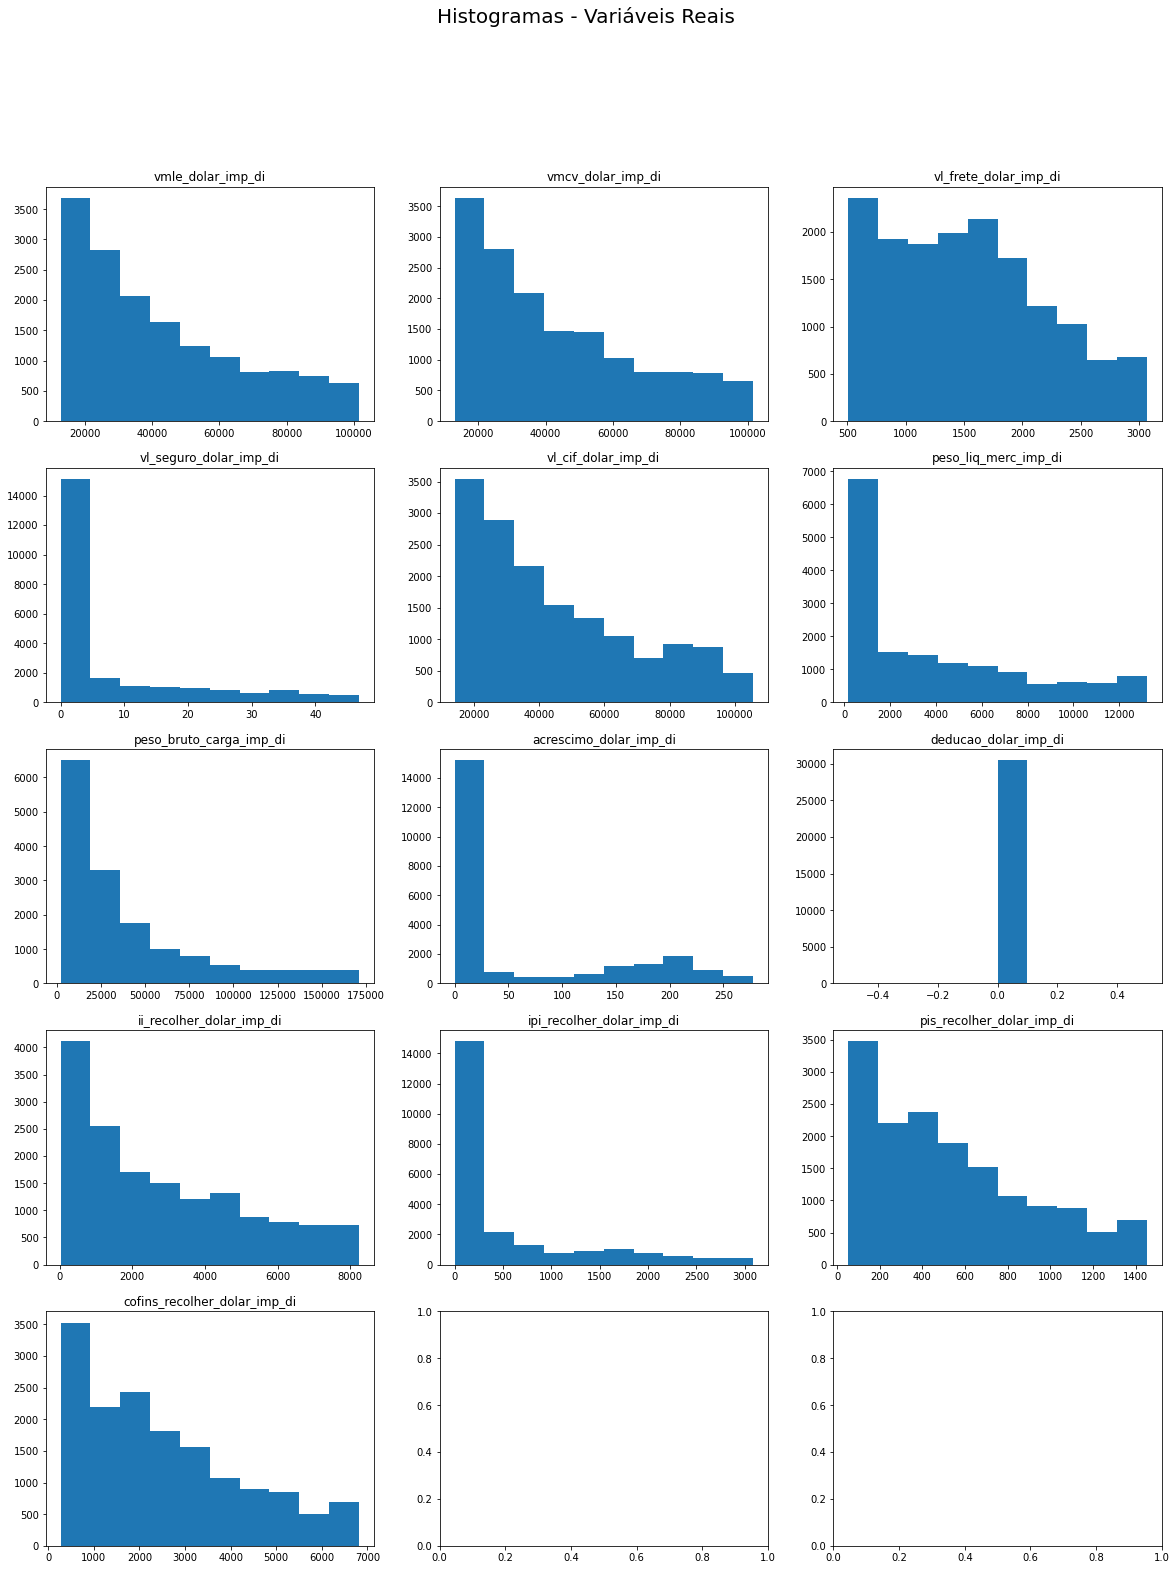

In [10]:
import math
# Display float columns distribution, so we can check if it is a Gaussian distribution
float_cols_qtty = len(float_columns)
fig, axis_list = plt.subplots(math.ceil(float_cols_qtty/3), 3, sharey=False, figsize=(20,25))
fig.suptitle('Histogramas - Variáveis Reais', fontsize=20)

ax_line = 0
ax_col  = 0

for col_name in float_columns:
    # Getting data between first and third quartiles, eliminating any outliers to improve the graphic display
    quantiles = train_enc_ncm_norm_df[col_name].quantile([0.25,0.75])
    # retrieving data to display as a histogram
    data = train_enc_ncm_norm_df[train_enc_ncm_norm_df[col_name].between(left=quantiles[0.25], right=quantiles[0.75])][col_name]

    ax = axis_list[ax_line][ax_col]
    ax.hist(data)
    ax.set_title(col_name)
    # Code to coltron in wich axis the data will be displayed
    ax_col += 1
    
    if ax_col > 2:
        ax_col = 0
        ax_line += 1

plt.show()

- Pela análise dos histogramas, nenhuma das colunas parece ter distribução normal
- Essa informação é confirmada pelo teste de Shapiro–Wilk

In [11]:
# Shapiro-Wilk Test
from scipy.stats import shapiro
import pandas as pd

res_df = {'coluna':[], 'valor-p':[], 'alpha':[], 'p>alpha':[], 'gaussiana':[]}
for col_name in float_columns:
    # normality test
    stat, p = shapiro(train_enc_ncm_norm_df[col_name])
    alpha = 0.05
    
    res_df['coluna'].append(col_name)
    res_df['valor-p'].append(p)
    res_df['alpha'].append(alpha)
    res_df['p>alpha'].append(p>alpha)
    res_df['gaussiana'].append(p>alpha)
    
res_df = pd.DataFrame(res_df)
res_df


/opt/anaconda3/lib/python3.6/site-packages/scipy/stats/morestats.py:1681: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


,coluna,valor-p,alpha,p>alpha,gaussiana
0,vmle_dolar_imp_di,0.00,0.05,False,False
1,vmcv_dolar_imp_di,0.00,0.05,False,False
2,vl_frete_dolar_imp_di,0.00,0.05,False,False
3,vl_seguro_dolar_imp_di,0.00,0.05,False,False
4,vl_cif_dolar_imp_di,0.00,0.05,False,False
5,peso_liq_merc_imp_di,0.00,0.05,False,False
6,peso_bruto_carga_imp_di,0.00,0.05,False,False
7,acrescimo_dolar_imp_di,0.00,0.05,False,False
8,deducao_dolar_imp_di,0.00,0.05,False,False
9,ii_recolher_dolar_imp_di,0.00,0.05,False,False


- Considerando que nenhuma das colunas possui distribuição normal, optar-se-á pela utilização da normalização dos dados em detrimento da padronização

#### Normalização, Dataframe: train_enc_ncm_df

In [12]:
# Instantiating MinMaxScaler pre-processing object
min_max_scaler = MinMaxScaler()
# Transforming - normalizing - the float columns. train_enc_ncm_norm_df has only the to be transformed columns 
X_scale = min_max_scaler.fit_transform(train_enc_ncm_norm_df)
# Creating a dataframe from the normalized columns, so it can be merged to the train_enc_ncm_df. It has to have the same index as the train_enc_ncm_df to be merged.
norm_df = pd.DataFrame(X_scale, index=train_enc_ncm_norm_df.index, columns=train_enc_ncm_norm_df.columns)
# Join normalized dataframe and train_enc_ncm_df, getting train_enc_ncm_norm_df
# In order to not gererate duplicated columns, the normalized columns have to be dropped from the train_enc_ncm_df before the merging
train_enc_ncm_norm_df = train_enc_ncm_df.drop(columns=float_columns).merge(norm_df, how='inner', left_index=True, right_index=True)
norm_df.head()

,vmle_dolar_imp_di,vmcv_dolar_imp_di,vl_frete_dolar_imp_di,vl_seguro_dolar_imp_di,vl_cif_dolar_imp_di,peso_liq_merc_imp_di,peso_bruto_carga_imp_di,acrescimo_dolar_imp_di,deducao_dolar_imp_di,ii_recolher_dolar_imp_di,ipi_recolher_dolar_imp_di,pis_recolher_dolar_imp_di,cofins_recolher_dolar_imp_di
32665,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00
6646,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.01,0.00,0.00
13468,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.01,0.00,0.00
44585,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
35455,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [13]:
# Evaluating encoded_ncm_normalized_df
eval_aux_df = util.evaluate_models(ds_name='ncm_encoded_norm', df=train_enc_ncm_norm_df, frac_di=0.5)
eval_df = eval_df.append(eval_aux_df)
eval_df

Testando Classifier: knn
Testando Classifier: log_reg
Testando Classifier: decision_tree
Testando Classifier: random_florest


knn  log_reg  decision_tree  \
ds_name               metric                                                
original_enc          fit_time_mean         45.47    53.42           7.28   
                      score_time_mean      119.89    22.51          11.58   
                      test_accuracy_mean     0.69     0.63           0.63   
                      train_accuracy_mean    0.80     0.63           0.63   
                      test_precision_mean    0.74     0.65           0.63   
                      train_precision_mean   0.83     0.66           0.62   
                      test_recall_mean       0.78     0.85           1.00   
                      train_recall_mean      0.86     0.85           1.00   
                      test_f1_mean           0.76     0.74           0.77   
                      train_f1_mean          0.84     0.74           0.77   
train_enc_ncm_df      fit_time_mean         41.84 1,552.19          16.43   
                      score_time_mean      210.62   102.85          26.61   
                      test_accuracy_mean     0.84     0.60           0.62   
                      train_accuracy_mean    0.89     0.60           0.63   
                      test_precision_mean    0.86     0.60           0.63   
                      train_precision_mean   0.91     0.60           0.64   
                      test_recall_mean       0.87     0.98           0.88   
                      train_recall_mean      0.91     0.98           0.89   
                      test_f1_mean           0.87     0.74           0.74   
                      train_f1_mean          0.91     0.75           0.74   
ncm_enc_di_level_full fit_time_mean          9.57    53.73           3.82   
                      score_time_mean       89.26    17.46           5.72   
                      test_accuracy_mean     0.55     0.51           0.59   
                      train_accuracy_mean    0.71     0.52           0.60   
                      test_precision_mean    0.55     0.53           0.59   
                      train_precision_mean   0.71     0.55           0.60   
                      test_recall_mean       0.56     0.20           0.64   
                      train_recall_mean      0.70     0.21           0.65   
                      test_f1_mean           0.55     0.28           0.59   
                      train_f1_mean          0.71     0.30           0.60   
ncm_encoded_norm      fit_time_mean         43.30   102.62          12.66   
                      score_time_mean      307.42    42.13          20.14   
                      test_accuracy_mean     0.85     0.62           0.66   
                      train_accuracy_mean    0.90     0.62           0.67   
                      test_precision_mean    0.87     0.63           0.70   
                      train_precision_mean   0.91     0.63           0.70   
                      test_recall_mean       0.88     0.96           0.82   
                      train_recall_mean      0.92     0.96           0.83   
                      test_f1_mean           0.88     0.76           0.75   
                      train_f1_mean          0.92     0.76           0.76   

                                            random_florest  
ds_name               metric                                
original_enc          fit_time_mean                   6.76  
                      score_time_mean                11.51  
                      test_accuracy_mean              0.63  
                      train_accuracy_mean             0.63  
                      test_precision_mean             0.62  
                      train_precision_mean            0.62  
                      test_recall_mean                1.00  
                      train_recall_mean               1.00  
                      test_f1_mean                    0.77  
                      train_f1_mean                   0.77  
train_enc_ncm_df      fit_time_mean                  15.15  
                  

#### Normalização, Dataframe: train_encoded_grouped_df

In [14]:
train_enc_ncm_group_norm = train_encoded_grouped_df[float_columns]
# Instantiating MinMaxScaler pre-processing object
min_max_scaler = MinMaxScaler()
# Transforming - normalizing - the float columns. train_enc_ncm_norm_df has only the to be transformed columns 
X_scale = min_max_scaler.fit_transform(train_enc_ncm_group_norm)
# Creating a dataframe from the normalized columns, so it can be merged to the train_enc_ncm_df. It has to have the same index as the train_enc_ncm_df to be merged.
norm_df = pd.DataFrame(X_scale, index=train_enc_ncm_group_norm.index, columns=train_enc_ncm_group_norm.columns)
# Join normalized dataframe and train_enc_ncm_df, getting train_enc_ncm_norm_df
# In order to not gererate duplicated columns, the normalized columns have to be dropped from the train_enc_ncm_df before the merging
train_enc_ncm_group_norm = train_encoded_grouped_df.drop(columns=float_columns).merge(norm_df, how='inner', left_index=True, right_index=True)
norm_df.head()

,vmle_dolar_imp_di,vmcv_dolar_imp_di,vl_frete_dolar_imp_di,vl_seguro_dolar_imp_di,vl_cif_dolar_imp_di,peso_liq_merc_imp_di,peso_bruto_carga_imp_di,acrescimo_dolar_imp_di,deducao_dolar_imp_di,ii_recolher_dolar_imp_di,ipi_recolher_dolar_imp_di,pis_recolher_dolar_imp_di,cofins_recolher_dolar_imp_di
0,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.03,0.00,0.00,0.00
1,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.00,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.01,0.00,0.01,0.01,0.00,0.00
4,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [15]:
# Evaluating encoded_ncm_normalized_df
eval_aux_df = util.evaluate_models(ds_name='ncm_encoded_group_norm', df=train_enc_ncm_group_norm, frac_di=0.5)
eval_df = eval_df.append(eval_aux_df)
eval_df

Testando Classifier: knn
Testando Classifier: log_reg
Testando Classifier: decision_tree
Testando Classifier: random_florest


knn  log_reg  decision_tree  \
ds_name                metric                                                
original_enc           fit_time_mean         45.47    53.42           7.28   
                       score_time_mean      119.89    22.51          11.58   
                       test_accuracy_mean     0.69     0.63           0.63   
                       train_accuracy_mean    0.80     0.63           0.63   
                       test_precision_mean    0.74     0.65           0.63   
                       train_precision_mean   0.83     0.66           0.62   
                       test_recall_mean       0.78     0.85           1.00   
                       train_recall_mean      0.86     0.85           1.00   
                       test_f1_mean           0.76     0.74           0.77   
                       train_f1_mean          0.84     0.74           0.77   
train_enc_ncm_df       fit_time_mean         41.84 1,552.19          16.43   
                       score_time_mean      210.62   102.85          26.61   
                       test_accuracy_mean     0.84     0.60           0.62   
                       train_accuracy_mean    0.89     0.60           0.63   
                       test_precision_mean    0.86     0.60           0.63   
                       train_precision_mean   0.91     0.60           0.64   
                       test_recall_mean       0.87     0.98           0.88   
                       train_recall_mean      0.91     0.98           0.89   
                       test_f1_mean           0.87     0.74           0.74   
                       train_f1_mean          0.91     0.75           0.74   
ncm_enc_di_level_full  fit_time_mean          9.57    53.73           3.82   
                       score_time_mean       89.26    17.46           5.72   
                       test_accuracy_mean     0.55     0.51           0.59   
                       train_accuracy_mean    0.71     0.52           0.60   
                       test_precision_mean    0.55     0.53           0.59   
                       train_precision_mean   0.71     0.55           0.60   
                       test_recall_mean       0.56     0.20           0.64   
                       train_recall_mean      0.70     0.21           0.65   
                       test_f1_mean           0.55     0.28           0.59   
                       train_f1_mean          0.71     0.30           0.60   
ncm_encoded_norm       fit_time_mean         43.30   102.62          12.66   
                       score_time_mean      307.42    42.13          20.14   
                       test_accuracy_mean     0.85     0.62           0.66   
                       train_accuracy_mean    0.90     0.62           0.67   
                       test_precision_mean    0.87     0.63           0.70   
                       train_precision_mean   0.91     0.63           0.70   
                       test_recall_mean       0.88     0.96           0.82   
                       train_recall_mean      0.92     0.96           0.83   
                       test_f1_mean           0.88     0.76           0.75   
                       train_f1_mean          0.92     0.76           0.76   
ncm_encoded_group_norm fit_time_mean          9.18    47.63           3.27   
                       score_time_mean       74.63    11.94           4.62   
                       test_accuracy_mean     0.55     0.52           0.59   
                       train_accuracy_mean    0.72     0.55           0.59   
                       test_precision_mean    0.55     0.53           0.62   
                       train_precision_mean   0.73     0.56           0.63   
                       test_recall_mean       0.51     0.39           0.44   
                       train_recall_mean      0.67     0.41           0.45   
                       test_f1_mean           0.53     0.45           0.51   
                       train_f1_mean          0.70     0.48          

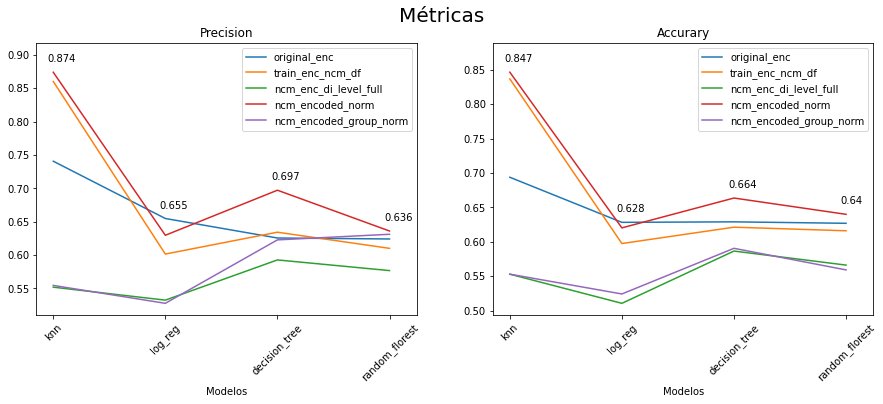

In [16]:
util.plot_eval_graphic(eval_df)

In [17]:
idx_slicer = pd.IndexSlice
display(pd.DataFrame(eval_df.loc[idx_slicer[:,'test_precision_mean'],:]['knn'].sort_values()))

display(pd.DataFrame(eval_df.loc[idx_slicer[:,'test_accuracy_mean'],:]['knn'].sort_values()))

,,knn
ds_name,metric,
ncm_enc_di_level_full,test_precision_mean,0.55
ncm_encoded_group_norm,test_precision_mean,0.55
original_enc,test_precision_mean,0.74
train_enc_ncm_df,test_precision_mean,0.86
ncm_encoded_norm,test_precision_mean,0.87


,,knn
ds_name,metric,
ncm_encoded_group_norm,test_accuracy_mean,0.55
ncm_enc_di_level_full,test_accuracy_mean,0.55
original_enc,test_accuracy_mean,0.69
train_enc_ncm_df,test_accuracy_mean,0.84
ncm_encoded_norm,test_accuracy_mean,0.85


### Retirando indentificadores dos intervenientes

In [18]:
train_enc_ncm_norm_nointerv_df = train_enc_ncm_norm_df.drop(columns=[
    'cd_respon_desemb_imp','cd_respon_regis_imp', 
    'nr_adquir'           , 'nr_agte_transpdr',
    'nr_impdr_expdr'      , 'nr_rep_legal'
])

eval_di_level_df = util.evaluate_models(ds_name='ncm_enc_norm_no_interv', df=train_enc_ncm_norm_nointerv_df, frac_di=0.5)
eval_df = eval_df.append(eval_di_level_df)
eval_df

Testando Classifier: knn
Testando Classifier: log_reg
Testando Classifier: decision_tree
Testando Classifier: random_florest


knn  log_reg  decision_tree  \
ds_name                metric                                                
original_enc           fit_time_mean         45.47    53.42           7.28   
                       score_time_mean      119.89    22.51          11.58   
                       test_accuracy_mean     0.69     0.63           0.63   
                       train_accuracy_mean    0.80     0.63           0.63   
                       test_precision_mean    0.74     0.65           0.63   
                       train_precision_mean   0.83     0.66           0.62   
                       test_recall_mean       0.78     0.85           1.00   
                       train_recall_mean      0.86     0.85           1.00   
                       test_f1_mean           0.76     0.74           0.77   
                       train_f1_mean          0.84     0.74           0.77   
train_enc_ncm_df       fit_time_mean         41.84 1,552.19          16.43   
                       score_time_mean      210.62   102.85          26.61   
                       test_accuracy_mean     0.84     0.60           0.62   
                       train_accuracy_mean    0.89     0.60           0.63   
                       test_precision_mean    0.86     0.60           0.63   
                       train_precision_mean   0.91     0.60           0.64   
                       test_recall_mean       0.87     0.98           0.88   
                       train_recall_mean      0.91     0.98           0.89   
                       test_f1_mean           0.87     0.74           0.74   
                       train_f1_mean          0.91     0.75           0.74   
ncm_enc_di_level_full  fit_time_mean          9.57    53.73           3.82   
                       score_time_mean       89.26    17.46           5.72   
                       test_accuracy_mean     0.55     0.51           0.59   
                       train_accuracy_mean    0.71     0.52           0.60   
                       test_precision_mean    0.55     0.53           0.59   
                       train_precision_mean   0.71     0.55           0.60   
                       test_recall_mean       0.56     0.20           0.64   
                       train_recall_mean      0.70     0.21           0.65   
                       test_f1_mean           0.55     0.28           0.59   
                       train_f1_mean          0.71     0.30           0.60   
ncm_encoded_norm       fit_time_mean         43.30   102.62          12.66   
                       score_time_mean      307.42    42.13          20.14   
                       test_accuracy_mean     0.85     0.62           0.66   
                       train_accuracy_mean    0.90     0.62           0.67   
                       test_precision_mean    0.87     0.63           0.70   
                       train_precision_mean   0.91     0.63           0.70   
                       test_recall_mean       0.88     0.96           0.82   
                       train_recall_mean      0.92     0.96           0.83   
                       test_f1_mean           0.88     0.76           0.75   
                       train_f1_mean          0.92     0.76           0.76   
ncm_encoded_group_norm fit_time_mean          9.18    47.63           3.27   
                       score_time_mean       74.63    11.94           4.62   
                       test_accuracy_mean     0.55     0.52           0.59   
                       train_accuracy_mean    0.72     0.55           0.59   
                       test_precision_mean    0.55     0.53           0.62   
                       train_precision_mean   0.73     0.56           0.63   
                       test_recall_mean       0.51     0.39           0.44   
                       train_recall_mean      0.67     0.41           0.45   
                       test_f1_mean           0.53     0.45           0.51   
                       train_f1_mean          0.70     0.48          

In [19]:
train_enc_ncm_group_norm_nointerv_df = train_enc_ncm_group_norm.drop(columns=[
    'cd_respon_desemb_imp','cd_respon_regis_imp', 
    'nr_adquir'           , 'nr_agte_transpdr',
    'nr_impdr_expdr'      , 'nr_rep_legal'
])

eval_di_level_df = util.evaluate_models(ds_name='ncm_enc_di_norm_no_interv', df=train_enc_ncm_group_norm_nointerv_df, frac_di=0.5)
eval_df = eval_df.append(eval_di_level_df)
eval_df

Testando Classifier: knn
Testando Classifier: log_reg
Testando Classifier: decision_tree
Testando Classifier: random_florest


knn  log_reg  decision_tree  \
ds_name                   metric                                                
original_enc              fit_time_mean         45.47    53.42           7.28   
                          score_time_mean      119.89    22.51          11.58   
                          test_accuracy_mean     0.69     0.63           0.63   
                          train_accuracy_mean    0.80     0.63           0.63   
                          test_precision_mean    0.74     0.65           0.63   
                          train_precision_mean   0.83     0.66           0.62   
                          test_recall_mean       0.78     0.85           1.00   
                          train_recall_mean      0.86     0.85           1.00   
                          test_f1_mean           0.76     0.74           0.77   
                          train_f1_mean          0.84     0.74           0.77   
train_enc_ncm_df          fit_time_mean         41.84 1,552.19          16.43   
                          score_time_mean      210.62   102.85          26.61   
                          test_accuracy_mean     0.84     0.60           0.62   
                          train_accuracy_mean    0.89     0.60           0.63   
                          test_precision_mean    0.86     0.60           0.63   
                          train_precision_mean   0.91     0.60           0.64   
                          test_recall_mean       0.87     0.98           0.88   
                          train_recall_mean      0.91     0.98           0.89   
                          test_f1_mean           0.87     0.74           0.74   
                          train_f1_mean          0.91     0.75           0.74   
ncm_enc_di_level_full     fit_time_mean          9.57    53.73           3.82   
                          score_time_mean       89.26    17.46           5.72   
                          test_accuracy_mean     0.55     0.51           0.59   
                          train_accuracy_mean    0.71     0.52           0.60   
                          test_precision_mean    0.55     0.53           0.59   
                          train_precision_mean   0.71     0.55           0.60   
                          test_recall_mean       0.56     0.20           0.64   
                          train_recall_mean      0.70     0.21           0.65   
                          test_f1_mean           0.55     0.28           0.59   
                          train_f1_mean          0.71     0.30           0.60   
ncm_encoded_norm          fit_time_mean         43.30   102.62          12.66   
                          score_time_mean      307.42    42.13          20.14   
                          test_accuracy_mean     0.85     0.62           0.66   
                          train_accuracy_mean    0.90     0.62           0.67   
                          test_precision_mean    0.87     0.63           0.70   
                          train_precision_mean   0.91     0.63           0.70   
                          test_recall_mean       0.88     0.96           0.82   
                          train_recall_mean      0.92     0.96           0.83   
                          test_f1_mean           0.88     0.76           0.75   
                          train_f1_mean          0.92     0.76           0.76   
ncm_encoded_group_norm    fit_time_mean          9.18    47.63           3.27   
                          score_time_mean       74.63    11.94           4.62   
                          test_accuracy_mean     0.55     0.52           0.59   
                          train_accuracy_mean    0.72     0.55           0.59   
                          test_precision_mean    0.55     0.53           0.62   
                          train_precision_mean   0.73     0.56           0.63   
                          test_recall_mean       0.51     0.39           0.44   
                          train_recall_mean      0.67     0.41           0.45   


### Avaliação dos modelos

- Melhor modelos (acurácia e precisão)
   - 1º: Knn
   - 2º: decision tree
- Melhores datasets
    - precisão: empate entre - ncm_encoded_norm_full, original, ncm_enc_norm_no_interv
    - acurácia: empate entre - ncm_encoded_norm_full, original, ncm_enc_norm_no_interv
    - acurácia e precisão do segundo colocado (decision tree): ncm_encoded_norm_full

- Para knn, optou-se por se utilizar o dataset original para variação de parâmetros, visto que é menor e teve o mesmo desempenho para acurácia e e precisão que os demais datasets.

- Para a variação de parâmetros da árvore de decisão, optou-se pela utilização do dataset ncm_encoded_norm_full, visto ter sido o que lhe trouxe o melhor resultado.



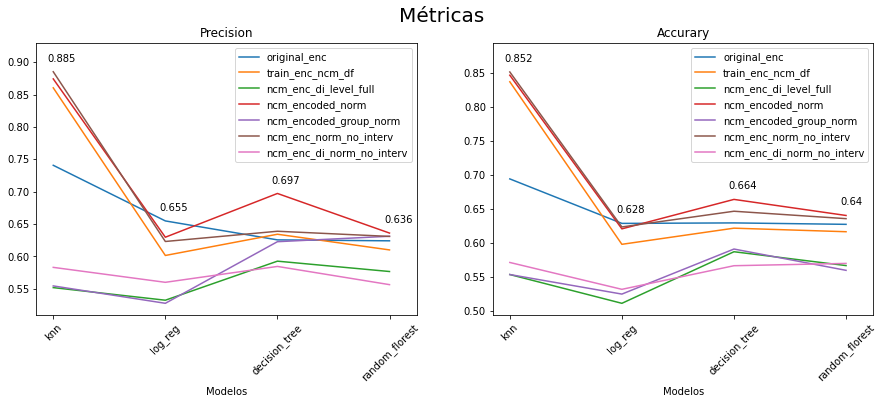

In [20]:
util.plot_eval_graphic(eval_df)

In [21]:
idx_slicer = pd.IndexSlice
display(pd.DataFrame(eval_df.loc[idx_slicer[:,'test_precision_mean'],:].sort_values(by='knn', ascending=False)))

display(pd.DataFrame(eval_df.loc[idx_slicer[:,'test_accuracy_mean'],:].sort_values(by='knn', ascending=False)))

,,knn,log_reg,decision_tree,random_florest
ds_name,metric,,,,
ncm_enc_norm_no_interv,test_precision_mean,0.89,0.62,0.64,0.63
ncm_encoded_norm,test_precision_mean,0.87,0.63,0.70,0.64
train_enc_ncm_df,test_precision_mean,0.86,0.60,0.63,0.61
original_enc,test_precision_mean,0.74,0.65,0.63,0.62
ncm_enc_di_norm_no_interv,test_precision_mean,0.58,0.56,0.58,0.56
ncm_encoded_group_norm,test_precision_mean,0.55,0.53,0.62,0.63
ncm_enc_di_level_full,test_precision_mean,0.55,0.53,0.59,0.58


,,knn,log_reg,decision_tree,random_florest
ds_name,metric,,,,
ncm_enc_norm_no_interv,test_accuracy_mean,0.85,0.62,0.65,0.64
ncm_encoded_norm,test_accuracy_mean,0.85,0.62,0.66,0.64
train_enc_ncm_df,test_accuracy_mean,0.84,0.60,0.62,0.62
original_enc,test_accuracy_mean,0.69,0.63,0.63,0.63
ncm_enc_di_norm_no_interv,test_accuracy_mean,0.57,0.53,0.57,0.57
ncm_enc_di_level_full,test_accuracy_mean,0.55,0.51,0.59,0.57
ncm_encoded_group_norm,test_accuracy_mean,0.55,0.52,0.59,0.56


In [22]:
pd.options.display.float_format = '{:,.4f}'.format

idx_slice = pd.IndexSlice

display(eval_df.loc[idx_slice[:,'test_accuracy_mean'],:].sort_values(by='knn', ascending=False))

display(eval_df.loc[idx_slice[:,'test_precision_mean'],:].sort_values(by='knn', ascending=False))

print('\nMelhor acurácia:')
acur_df = eval_df.loc[idx_slice[:,'test_accuracy_mean'],:]
best_accuracy = acur_df.max().max()
display(acur_df[acur_df == best_accuracy ].dropna(how='all').dropna(axis=1, how='all'))

print('\nMelhor acurária sem KNN:')
sec_best_accuracy = acur_df[(acur_df < best_accuracy)].drop(columns=['knn']).max().max()
display(acur_df[acur_df == sec_best_accuracy ].dropna(how='all').dropna(axis=1, how='all'))

print('\nMelhor precisão:')
prec_df = eval_df.loc[idx_slice[:,'test_precision_mean'],:]
best_precision = prec_df.max().max()
display(prec_df[prec_df == best_precision ].dropna(how='all').dropna(axis=1, how='all'))

print('\nMelhor precisão sem KNN:')
sec_best_precision = prec_df[(prec_df < best_precision)].drop(columns=['knn']).max().max()
display(prec_df[prec_df == sec_best_precision ].dropna(how='all').dropna(axis=1, how='all'))
pd.options.display.float_format = '{:,.2f}'.format

,,knn,log_reg,decision_tree,random_florest
ds_name,metric,,,,
ncm_enc_norm_no_interv,test_accuracy_mean,0.8515,0.6231,0.6463,0.6353
ncm_encoded_norm,test_accuracy_mean,0.8467,0.6203,0.6637,0.6400
train_enc_ncm_df,test_accuracy_mean,0.8370,0.5975,0.6213,0.6161
original_enc,test_accuracy_mean,0.6939,0.6284,0.6291,0.6270
ncm_enc_di_norm_no_interv,test_accuracy_mean,0.5708,0.5312,0.5660,0.5694
ncm_enc_di_level_full,test_accuracy_mean,0.5530,0.5106,0.5866,0.5662
ncm_encoded_group_norm,test_accuracy_mean,0.5530,0.5242,0.5906,0.5592


,,knn,log_reg,decision_tree,random_florest
ds_name,metric,,,,
ncm_enc_norm_no_interv,test_precision_mean,0.8852,0.6231,0.6389,0.6310
ncm_encoded_norm,test_precision_mean,0.8741,0.6297,0.6973,0.6361
train_enc_ncm_df,test_precision_mean,0.8604,0.6015,0.6343,0.6101
original_enc,test_precision_mean,0.7408,0.6549,0.6256,0.6242
ncm_enc_di_norm_no_interv,test_precision_mean,0.5832,0.5601,0.5846,0.5565
ncm_encoded_group_norm,test_precision_mean,0.5545,0.5277,0.6228,0.6312
ncm_enc_di_level_full,test_precision_mean,0.5519,0.5325,0.5928,0.5768



Melhor acurácia:


,,knn
ds_name,metric,
ncm_enc_norm_no_interv,test_accuracy_mean,0.8515



Melhor acurária sem KNN:


,,decision_tree
ds_name,metric,
ncm_encoded_norm,test_accuracy_mean,0.6637



Melhor precisão:


,,knn
ds_name,metric,
ncm_enc_norm_no_interv,test_precision_mean,0.8852



Melhor precisão sem KNN:


,,decision_tree
ds_name,metric,
ncm_encoded_norm,test_precision_mean,0.6973


### Gridsearch

In [23]:
# KNN
knn_clf = KNeighborsClassifier()

df_sample = util.get_di_sample(df=train_enc_ncm_norm_nointerv_df, frac_di=0.5)

X = df_sample.drop(columns=['retificada', 'cd_di'], inplace=False)
y = df_sample['retificada']

params={
    'n_neighbors':[3, 5, 9], 
    'weights'    :['uniform'  , 'distance'],
    'metric'     :['euclidean', 'manhattan']  # the distance metric
}

classificadorGrid = GridSearchCV(
    estimator=knn_clf, 
    scoring='precision',
    param_grid=params, 
    verbose=1, 
    cv=3, 
    n_jobs=3,
    refit=True, # The classificatorGrid will return an estimator fitted with the best parameters
    
)

# The classificatorGrid will return an estimator fitted with the best parameters
classificadorGrid.fit(X, y)
best_knn_clf = classificadorGrid.best_estimator_
print("\nClassificado usando KNN com GridSearch")
print(f"Melhores parâmetros encontrados: {classificadorGrid.best_params_}")
print(f"Melhor score: {classificadorGrid.best_score_}")

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  36 out of  36 | elapsed: 45.1min finished



Classificado usando KNN com GridSearch
Melhores parâmetros encontrados: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Melhor score: 0.9131298327702437


In [24]:
best_knn_clf = classificadorGrid.best_estimator_
best_knn_clf.classes_

array([0, 1])

In [25]:
# Gettin data for test
cond = ~train_enc_ncm_norm_nointerv_df['cd_di'].isin(df_sample['cd_di'])
df_sample_test = util.get_di_sample(df=train_enc_ncm_norm_nointerv_df[cond], frac_di=0.125)
X_test = df_sample_test.drop(columns=['retificada', 'cd_di'], inplace=False)
y_test = df_sample_test['retificada']

# Predicintg y__pred based on X_test
y_pred = best_knn_clf.predict(X_test)


              precision    recall  f1-score   support

           0       0.40      0.41      0.40       634
           1       0.66      0.65      0.65      1119

   micro avg       0.56      0.56      0.56      1753
   macro avg       0.53      0.53      0.53      1753
weighted avg       0.56      0.56      0.56      1753

Matriz de confusão sem normalização
[[258 376]
 [395 724]]


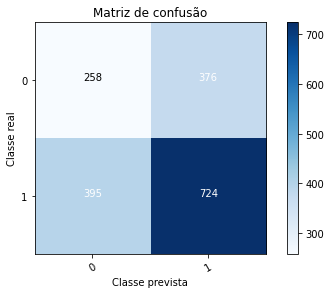

In [26]:
clas_report = classification_report(y_test, y_pred, target_names=best_knn_clf.classes_.astype('str'))
print(clas_report)

# Confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=best_knn_clf.classes_)
util.plot_confusion_matrix(
        cnf_matrix, 
        best_knn_clf.classes_, 
        normalize=False,
        title="Matriz de confusão",
        cmap=plt.cm.Blues)


### Random search

In [27]:
# Árvore de decisão
dtree_clf = DecisionTreeClassifier(random_state=0)

params={
        'criterion':('gini','entropy'), 
        'min_samples_leaf':[1, 2, 3],
        'min_impurity_decrease':[0.01, 0.05, 0.1, 0.15]}

classRandomSearch = RandomizedSearchCV(
    estimator=dtree_clf, 
    param_distributions=params, 
    n_iter=500, 
    scoring='precision', 
    n_jobs=3, 
    cv=3, 
    random_state=1,
    refit=True)

df_sample = util.get_di_sample(df=train_enc_ncm_norm_df, frac_di=0.5)

X = df_sample.drop(columns=['retificada', 'cd_di'], inplace=False)
y = df_sample['retificada']

best_dtree_clf = classRandomSearch.fit(X, y)

print("\nClassificado usando KNN com GridSearch")
print(f"Best parameters set found on development set: {classRandomSearch.best_params_}")
print(f"Melhor score com 50% ds DIs: {classRandomSearch.best_score_}")

/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 24 is smaller than n_iter=500. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)



Classificado usando KNN com GridSearch
Best parameters set found on development set: {'min_samples_leaf': 1, 'min_impurity_decrease': 0.01, 'criterion': 'entropy'}
Melhor score com 50% ds DIs: 0.7321587602914751


              precision    recall  f1-score   support

           0       0.52      0.31      0.39       945
           1       0.51      0.71      0.59       934

   micro avg       0.51      0.51      0.51      1879
   macro avg       0.52      0.51      0.49      1879
weighted avg       0.52      0.51      0.49      1879

Matriz de confusão sem normalização
[[295 650]
 [267 667]]


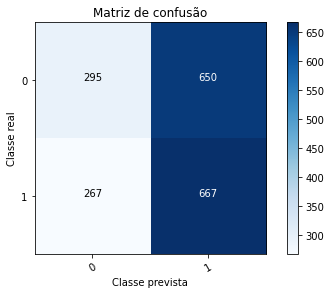

In [28]:
# Gettin data for test
cond = ~train_enc_ncm_norm_df['cd_di'].isin(df_sample['cd_di'])
df_sample_test = util.get_di_sample(df=train_enc_ncm_norm_df[cond], frac_di=0.125)
X_test = df_sample_test.drop(columns=['retificada', 'cd_di'], inplace=False)
y_test = df_sample_test['retificada']

# Predicintg y__pred based on X_test
y_pred = best_dtree_clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=best_dtree_clf.classes_.astype('str')))


# Calcula a matriz de confusão
cnf_matrix = confusion_matrix(y_test, y_pred, labels=best_dtree_clf.classes_)

# Plot normalized confusion matrix
util.plot_confusion_matrix(
        cnf_matrix, 
        best_dtree_clf.classes_, 
        normalize=False,
        title="Matriz de confusão",
        cmap=plt.cm.Blues)



#### RandonSearch - Dataset - Nível da Di

In [29]:
# Árvore de decisão
dtree_clf = DecisionTreeClassifier(random_state=0)

params={
        'criterion':('gini','entropy'), 
        'min_samples_leaf':[1, 2, 3],
        'min_impurity_decrease':[0.01, 0.05, 0.1, 0.15]}

classRandomSearch = RandomizedSearchCV(
    estimator=dtree_clf, 
    param_distributions=params, 
    n_iter=500, 
    scoring='precision', 
    n_jobs=3, 
    cv=3, 
    random_state=1,
    refit=True)

df_sample = util.get_di_sample(df=train_enc_ncm_group_norm, frac_di=0.5)

X = df_sample.drop(columns=['retificada', 'cd_di'], inplace=False)
y = df_sample['retificada']

best_dtree_clf = classRandomSearch.fit(X, y)

print("\nClassificado usando KNN com GridSearch")
print(f"Best parameters set found on development set: {classRandomSearch.best_params_}")
print(f"Melhor score com 50% ds DIs: {classRandomSearch.best_score_}")

/opt/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:271: UserWarning: The total space of parameters 24 is smaller than n_iter=500. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)



Classificado usando KNN com GridSearch
Best parameters set found on development set: {'min_samples_leaf': 1, 'min_impurity_decrease': 0.01, 'criterion': 'entropy'}
Melhor score com 50% ds DIs: 0.6269748128989208


              precision    recall  f1-score   support

           0       0.55      0.69      0.62       313
           1       0.59      0.44      0.51       312

   micro avg       0.57      0.57      0.57       625
   macro avg       0.57      0.57      0.56       625
weighted avg       0.57      0.57      0.56       625

Matriz de confusão sem normalização
[[217  96]
 [174 138]]


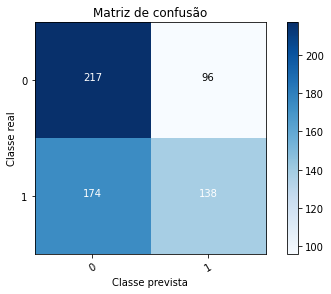

In [30]:
# Gettin data for test
cond = ~train_enc_ncm_group_norm['cd_di'].isin(df_sample['cd_di'])
df_sample_test = util.get_di_sample(df=train_enc_ncm_group_norm[cond], frac_di=0.125)
X_test = df_sample_test.drop(columns=['retificada', 'cd_di'], inplace=False)
y_test = df_sample_test['retificada']

# Predicintg y__pred based on X_test
y_pred = best_dtree_clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=best_dtree_clf.classes_.astype('str')))


# Calcula a matriz de confusão
cnf_matrix = confusion_matrix(y_test, y_pred, labels=best_dtree_clf.classes_)

# Plot normalized confusion matrix
util.plot_confusion_matrix(
        cnf_matrix, 
        best_dtree_clf.classes_, 
        normalize=False,
        title="Matriz de confusão",
        cmap=plt.cm.Blues)